# MIDS - w261 Machine Learning At Scale
__Course Lead:__ Dr James G. Shanahan (__email__ Jimi via  James.Shanahan _AT_ gmail.com)

## Assignment - HW5 Phase 2


---
__Name:__  Leslie Teo; Stanimir Vichev; Seung Hun Ham  
__Class:__ MIDS w261 Spring 2018 Section 1     
__Email:__  lteo@iSchool.berkeley.edu; stassyvichev@berkeley.edu; seung.ham@ischool.berkeley.edu     
__StudentId__  303218617; 3032580461; 20957715    __End of StudentId__   
__Week:__   5.5

__NOTE:__ please replace `1234567` with your student id above      
__Due Time:__ HW is due the Thursday of the following week by 8AM (West coast time).

* __HW5 Phase 1__ 
This can be done on a local machine (with a unit test on the cloud such as Altiscale's PaaS or on AWS) and is due Thursday, Week 6 by 8AM (West coast time). It will primarily focus on building a unit/systems and for pairwise similarity calculations pipeline (for stripe documents)

* __HW5 Phase 2__ 
This will require the Altiscale cluster and will be due Thursday of the following week by 8AM (West coast time). 
The focus of  HW5 Phase 2  will be to scale up the unit/systems tests to the Google 5 gram corpus. 

# Datasets

For Phase 2 you will first use the small datasets from phase 1 to systems test your code in the cloud. Then you will test your code on 1 file and then 20 files before running the full (191 file) Google n-gram dataset.

__Small data for systems tests__

In [2]:
%%writefile atlas-boon-systems-test.txt
atlas boon	50	50	50
boon cava dipped	10	10	10
atlas dipped	15	15	15

Overwriting atlas-boon-systems-test.txt


In [3]:
%%writefile googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt
A BILL FOR ESTABLISHING RELIGIOUS	59	59	54
A Biography of General George	92	90	74
A Case Study in Government	102	102	78
A Case Study of Female	447	447	327
A Case Study of Limited	55	55	43
A Child's Christmas in Wales	1099	1061	866
A Circumstantial Narrative of the	62	62	50
A City by the Sea	62	60	49
A Collection of Fairy Tales	123	117	80
A Collection of Forms of	116	103	82

Overwriting googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt


SETUP: __Paths to Main data in HDFS on Altiscale AND OTHER SETTINGS__

In [3]:
TEST_1 = "/user/winegarj/data/1_test"
TEST_20 = "/user/winegarj/data/20_test"
FULL_DATA = "/user/winegarj/data/full" 
import os
USER = !whoami
USER = USER[0]
OUTPUT_PATH_BASE = '/user/{USER}'.format(USER=USER)

# Set - Up for Phase 2
Before you can run your simlarity analysis on the full Google n-gram dataset you should confirm that the code your wrote in Phase 1 works on the cloud. In the space below, copy the code for your three jobs from Phase 1 (`buildStripes.py`, `invertedIndex.py`, `similarity.py`) and rerun your  atlas-boon systems tests on Altiscale (i.e. ** the cloud**). NOTE: _you may end up modifying this code when you get to 5.7, that's fine._

### `buildStripes.py` Note: changed to `buildStripes_v2.py`

In [4]:
%%writefile buildStripes_v2.py
#!~/opt/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools

class MRbuildStripes(MRJob):
    SORT_VALUES = True
    
    def mapper(self, _, line):
        fields = line.lower().strip("\n").split("\t")
        words = fields[0].split(" ")
        occurrence_count = int(fields[1])
        for subset in itertools.combinations(sorted(set(words)), 2):
            yield subset[0], (subset[1], occurrence_count)
            yield subset[1], (subset[0], occurrence_count)
    
    def reducer(self, word, occurrence_counts):
        stripe = {}
        for other_word, occurrence_count in occurrence_counts:
            stripe[other_word] = stripe.get(other_word,0)+occurrence_count
        yield word, stripe

if __name__ == '__main__':
    MRbuildStripes.run()

Overwriting buildStripes_v2.py


### `invertedIndex.py` Note: changed to `invertedIndex_v2.py`

In [5]:
%%writefile invertedIndex_v2.py
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import division
import collections
import sys
import re
import json
import math
import numpy as np
import itertools
import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class MRinvertedIndex(MRJob):
    
    #START SUDENT CODE531_INV_INDEX
    
    SORT_VALUES = True
    
    def steps(self):
        
        JOBCONF_STEP = {
                'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                'mapreduce.partition.keycomparator.options': '-k1'
                }  
        return [
        MRStep(jobconf=JOBCONF_STEP, 
               mapper=self.mapper,
               reducer=self.reducer)
        ]
    
    def mapper(self, _, line):
        sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")
        
        tokens = line.strip().split('\t')
        value_dict = json.loads(tokens[1])
        term_len = len(value_dict)
        
        for key in value_dict.keys():
            yield key, [tokens[0], term_len]

            
    def reducer(self, key, values):
        sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")
        out = []
        for value_dict in values:
            value_dict[0] = value_dict[0].replace('"','')
            out.append(value_dict)
        
        yield key, out


  #END SUDENT CODE531_INV_INDEX
        
if __name__ == '__main__':
    MRinvertedIndex.run() 

Writing invertedIndex_v2.py


### `similarity.py` Note: changed to `similarity_v2.py`

In [2]:
%%writefile similarity_cosine_sort.py
#!/usr/bin/env python
# -*- coding: utf-8 -*-

from __future__ import division
import sys
import collections
import re
import json
import math
import numpy as np
import itertools
import mrjob
from operator import itemgetter
from mrjob.protocol import RawProtocol
from mrjob.protocol import JSONProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import logging

class MRsimilarity(MRJob):
    
    SORT_VALUES = True
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol
    
    def __init__(self, *args, **kwargs):
        super(MRsimilarity, self).__init__(*args, **kwargs)
        self.N = 25
        self.NUM_REDUCERS = 25
        
    def steps(self):
        JOBCONF_STEP_1 = {
                "mapreduce.job.reduces": "128",
                "mapreduce.job.maps": "128",
                }
        
        JOBCONF_STEP_2 = {
                'stream.num.map.output.key.fields':3,
                'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                'stream.map.output.field.separator':"\t",
                'mapreduce.partition.keypartitioner.options':'-k1,1',
                'mapreduce.partition.keycomparator.options':'-k2,2nr -k3,3',
                'mapred.reduce.tasks': self.NUM_REDUCERS,
                'partitioner':'org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner',
                "mapreduce.job.reduces": str(self.NUM_REDUCERS),
                "SORT_VALUES":True,
                "INTERNAL_PROTOCOL":"RawProtocol",
                "OUTPUT_PROTOCOL":"RawProtocol"
                }  
         
        return [
        MRStep(jobconf=JOBCONF_STEP_1,
               mapper=self.mapper_pair_sim,
               combiner = self.combiner_pair_sim,
               reducer=self.reducer_pair_sim
            ),
        MRStep(jobconf=JOBCONF_STEP_2, 
               mapper_init=self.mapper_sort_init,
               mapper= self.mapper_sort,
               reducer=self.reducer_sort
            )
        ]

    def mapper_pair_sim(self, _, line):     
        sys.stderr.write("reporter:counter:Mapper Counters,Calls,1\n")
        line = line.strip()
        index, posting = line.split('\t')
        posting = json.loads(posting)
        posting = dict(posting)
        logging.warning(line)
        logging.warning(posting)
        for docs in itertools.combinations(sorted(posting.keys()), 2):
            yield ",".join([docs[0],docs[1], str(posting[docs[0]]), str(posting[docs[1]])]),str(1)
        
    
    def combiner_pair_sim(self, key, values):
        yield key,str(sum([int(v) for v in values]))
        
    def reducer_pair_sim(self, key, values):
        sys.stderr.write("reporter:counter:Reducer Counters,Calls,1\n")
        total = sum([float(v) for v in values])
        key = key.split(",")
        key[2] = float(key[2])
        key[3] = float(key[3])
        cosine = total/(np.sqrt(key[2])*np.sqrt(key[3]))
        jacard = total/(key[2]+key[3]-total)
        overlap = total/min(key[2],key[3])
        dice = 2*total/(key[2]+key[3])
        yield None, str(cosine) +"\t"+"[" +",".join(["\""+ key[0]+" - "+key[1]+"\"",str(np.mean([cosine, jacard, overlap, dice])),str(jacard),str(overlap),str(dice)])+"]"

    def mapper_sort_init(self):
        def makeKeyHash(key, num_reducers):
            byteof = lambda char: int(format(ord(char), 'b'), 2)
            current_hash = 0
            for c in key:
                current_hash = (current_hash * 31 + byteof(c))
            return current_hash % num_reducers
        
        # printable ascii characters, starting with 'A'
        keys = [str(unichr(i)) for i in range(65,65+self.NUM_REDUCERS)]
        partitions = []

        for key in keys:
            partitions.append([key, makeKeyHash(key, self.NUM_REDUCERS)])

        parts = sorted(partitions,key=itemgetter(1))
        self.partition_keys = list(np.array(parts)[:,0])

        self.partition_file = np.arange(0,self.N,self.N/(self.NUM_REDUCERS))[::-1]

        
    
    def mapper_sort(self, key, value):
        keyFloatScaled = np.floor(float(key)*self.N)
        # Prepend the approriate key by finding the bucket, and using the index to fetch the key.
        for idx in xrange(self.NUM_REDUCERS):
            if keyFloatScaled > self.partition_file[idx]:
                yield str(self.partition_keys[idx]),key+" \t "+value
                break
        
    def reducer_sort(self, key, values):
        sys.stderr.write("reporter:counter:Intermediate Reducer Counters,Calls,1\n")
        for value in values:
            yield None, value

if __name__ == '__main__':
    MRsimilarity.run()

Writing similarity_cosine_sort.py


#### atlas-boon systems test

In [7]:
!python buildStripes_v2.py \
    -r local atlas-boon-systems-test.txt

Using configs in /home/seungham/.mrjob.conf
Creating temp directory /tmp/buildStripes_v2.seungham.20180307.045907.814934
Running step 1 of 1...
Streaming final output from /tmp/buildStripes_v2.seungham.20180307.045907.814934/output...
"boon"	{"atlas":50,"dipped":10,"cava":10}
"cava"	{"dipped":10,"boon":10}
"dipped"	{"atlas":15,"boon":10,"cava":10}
"atlas"	{"dipped":15,"boon":50}
Removing temp directory /tmp/buildStripes_v2.seungham.20180307.045907.814934...


In [8]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests_atlas')
!hadoop fs -rm -r {OUTPUT_PATH}

!python buildStripes_v2.py \
        -r hadoop atlas-boon-systems-test.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output
    

rm: `/user/seungham/tests_atlas': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripes_v2.seungham.20180307.045920.436129
Copying local files to hdfs:///user/seungham/tmp/mrjob/buildStripes_v2.seungham.20180307.045920.436129/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6671274293872945324.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http:

In [9]:
!hadoop fs -cat {OUTPUT_PATH}/*

"atlas"	{"dipped": 15, "boon": 50}
"boon"	{"atlas": 50, "dipped": 10, "cava": 10}
"cava"	{"dipped": 10, "boon": 10}
"dipped"	{"atlas": 15, "boon": 10, "cava": 10}


In [10]:
# Save into file for processing
!hadoop fs -cat {OUTPUT_PATH}/* > test_stripes_1

In [11]:
# Testing inverted index
!python invertedIndex_v2.py \
    -r local test_stripes_1

Using configs in /home/seungham/.mrjob.conf
Creating temp directory /tmp/invertedIndex_v2.seungham.20180307.050039.371820
Running step 1 of 1...

Counters: 2
	Mapper Counters
		Calls=4
	Reducer Counters
		Calls=4

Streaming final output from /tmp/invertedIndex_v2.seungham.20180307.050039.371820/output...
"boon"	[["atlas",2],["cava",2],["dipped",3]]
"cava"	[["boon",3],["dipped",3]]
"dipped"	[["atlas",2],["boon",3],["cava",2]]
"atlas"	[["boon",3],["dipped",3]]
Removing temp directory /tmp/invertedIndex_v2.seungham.20180307.050039.371820...


In [12]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!python invertedIndex_v2.py \
        -r hadoop test_stripes_1 \
        --output-dir={OUTPUT_PATH} \
        --no-output
    

18/03/07 05:00:44 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex_v2.seungham.20180307.050045.856073
Copying local files to hdfs:///user/seungham/tmp/mrjob/invertedIndex_v2.seungham.20180307.050045.856073/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6910304249563958662.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.c

In [13]:
# Save into file for processing
!hadoop fs -cat {OUTPUT_PATH}/* > test_index_1
!cat test_index_1

"atlas"	[["boon", 3], ["dipped", 3]]
"boon"	[["atlas", 2], ["cava", 2], ["dipped", 3]]
"cava"	[["boon", 3], ["dipped", 3]]
"dipped"	[["atlas", 2], ["boon", 3], ["cava", 2]]


In [14]:
##########################################################
# Pretty print systems tests for generating Inverted Index
##########################################################

import json

for i in range(1,2):
    print "—"*100
    print "Systems test ",i," - Inverted Index"
    print "—"*100  
    with open("test_index_"+str(i),"r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            word,stripe = line.split("\t")
            stripe = json.loads(stripe)
            stripe.extend([["",""] for _ in xrange(3 - len(stripe))])

            print "{0:>16} |{1:>16} |{2:>16} |{3:>16}".format((word), 
                stripe[0][0]+" "+str(stripe[0][1]), stripe[1][0]+" "+str(stripe[1][1]), stripe[2][0]+" "+str(stripe[2][1]))

————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Inverted Index
————————————————————————————————————————————————————————————————————————————————————————————————————
         "atlas" |          boon 3 |        dipped 3 |                
          "boon" |         atlas 2 |          cava 2 |        dipped 3
          "cava" |          boon 3 |        dipped 3 |                
        "dipped" |         atlas 2 |          boon 3 |          cava 2


In [15]:
# Testing similarity metrics
# SORTED BY AVG
!python similarity_v2.py \
    -r local test_index_1

Using configs in /home/seungham/.mrjob.conf
Creating temp directory /tmp/similarity_v2.seungham.20180307.050146.297655
Running step 1 of 2...

Counters: 2
	Mapper Counters
		Calls=4
	Reducer Counters
		Calls=6

Running step 2 of 2...

Counters: 1
	Intermediate Reducer Counters
		Calls=3

Streaming final output from /tmp/similarity_v2.seungham.20180307.050146.297655/output...
1.0 	 ["atlas - cava",0.9999999999999998,1.0,1.0,1.0]
0.625 	 ["boon - dipped",0.6666666666666667,0.5,0.666666666667,0.666666666667]
0.38956207261596576 	 ["atlas - boon",0.40824829046386296,0.25,0.5,0.4]
0.38956207261596576 	 ["atlas - dipped",0.40824829046386296,0.25,0.5,0.4]
0.38956207261596576 	 ["boon - cava",0.40824829046386296,0.25,0.5,0.4]
0.38956207261596576 	 ["cava - dipped",0.40824829046386296,0.25,0.5,0.4]
Removing temp directory /tmp/similarity_v2.seungham.20180307.050146.297655...


In [4]:
# Run in Hadoop
# SORTED BY cosine
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!python similarity_cosine_sort.py \
        -r hadoop test_index_1 \
        --output-dir={OUTPUT_PATH} \
        --no-output
    

18/03/07 21:29:15 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/.Trash/Current
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity_cosine_sort.stassyvichev.20180307.212916.434579
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/similarity_cosine_sort.stassyvichev.20180307.212916.434579/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8045743363388620350.jar tmpDir=null
  Timeline service a

Removing temp directory /tmp/similarity_cosine_sort.stassyvichev.20180307.212916.434579...


In [5]:
# Save into file for processing
!hadoop fs -cat {OUTPUT_PATH}/* > test_similarities_1
!cat test_similarities_1

1.0 	 ["atlas - cava",1.0,1.0,1.0,1.0]	
0.666666666667 	 ["boon - dipped",0.625,0.5,0.666666666667,0.666666666667]	
0.408248290464 	 ["atlas - boon",0.389562072616,0.25,0.5,0.4]	
0.408248290464 	 ["atlas - dipped",0.389562072616,0.25,0.5,0.4]	
0.408248290464 	 ["boon - cava",0.389562072616,0.25,0.5,0.4]	
0.408248290464 	 ["cava - dipped",0.389562072616,0.25,0.5,0.4]	


In [6]:
############################################
# Pretty print systems tests
# Note: adjust print formatting if you need to
############################################

import json
for i in range(1,2):
    print '—'*110
    print "Systems test ",i," - Similarity measures"
    print '—'*110
    print "{0:>15} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
    "cosine", "pair", "average", "jaccard", "overlap", "dice")
    print '-'*110

    with open("test_similarities_"+str(i),"r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            avg,stripe = line.split("\t")
            stripe = json.loads(stripe)
            
            print "{0:>15f} |{1:>15} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(float(avg),
                stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]))

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Similarity measures
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
         cosine |           pair |        average |        jaccard |        overlap |           dice
--------------------------------------------------------------------------------------------------------------
       1.000000 |   atlas - cava |       1.000000 |       1.000000 |       1.000000 |       1.000000
       0.666667 |  boon - dipped |       0.625000 |       0.500000 |       0.666667 |       0.666667
       0.408248 |   atlas - boon |       0.389562 |       0.250000 |       0.500000 |       0.400000
       0.408248 | atlas - dipped |       0.389562 |       0.250000 |       0.500000 |       0.400000
       0.408248 |    boon - cava |       0.389562 |       0.250000 |       0.500000 |       0.400000
       0.408248 |  cav



#### 10-line systems test

In [19]:
# Build Stripes

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python buildStripes_v2.py \
        -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output

!hadoop fs -cat {OUTPUT_PATH}/* > test_stripes_2



18/03/07 05:04:47 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripes_v2.seungham.20180307.050447.961618
Copying local files to hdfs:///user/seungham/tmp/mrjob/buildStripes_v2.seungham.20180307.050447.961618/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4308553809283552618.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com

In [20]:
!cat test_stripes_2

"a"	{"limited": 55, "sea": 62, "general": 92, "female": 447, "in": 1201, "religious": 59, "george": 92, "biography": 92, "city": 62, "for": 59, "tales": 123, "government": 102, "the": 124, "forms": 116, "wales": 1099, "christmas": 1099, "child's": 1099, "collection": 239, "by": 62, "case": 604, "circumstantial": 62, "of": 895, "study": 604, "bill": 59, "establishing": 59, "narrative": 62, "fairy": 123}
"bill"	{"a": 59, "religious": 59, "for": 59, "establishing": 59}
"biography"	{"a": 92, "of": 92, "george": 92, "general": 92}
"by"	{"a": 62, "city": 62, "the": 62, "sea": 62}
"case"	{"a": 604, "limited": 55, "government": 102, "of": 502, "study": 604, "female": 447, "in": 102}
"child's"	{"a": 1099, "wales": 1099, "christmas": 1099, "in": 1099}
"christmas"	{"a": 1099, "wales": 1099, "in": 1099, "child's": 1099}
"circumstantial"	{"a": 62, "of": 62, "the": 62, "narrative": 62}
"city"	{"a": 62, "the": 62, "by": 62, "sea": 62}
"collection"	{"a": 239, "forms": 116, "fairy": 123, "tales": 123, 

In [21]:
# Build Inverted Index

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python invertedIndex_v2.py \
        -r hadoop test_stripes_2 \
        --output-dir={OUTPUT_PATH} \
        --no-output
        
!hadoop fs -cat {OUTPUT_PATH}/* > test_index_2

18/03/07 05:05:38 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex_v2.seungham.20180307.050538.944841
Copying local files to hdfs:///user/seungham/tmp/mrjob/invertedIndex_v2.seungham.20180307.050538.944841/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8233409238761262420.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.c

In [7]:
# Calculate Similarity

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python similarity_cosine_sort.py \
        -r hadoop test_index_2 \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/03/07 21:33:54 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/.Trash/Current
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity_cosine_sort.stassyvichev.20180307.213354.975708
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/similarity_cosine_sort.stassyvichev.20180307.213354.975708/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4543019750679287203.jar tmpDir=null
  Timeline service a

Removing temp directory /tmp/similarity_cosine_sort.stassyvichev.20180307.213354.975708...

real	8m58.184s
user	0m52.301s
sys	0m2.686s


In [8]:
!hadoop fs -cat {OUTPUT_PATH}/* > test_similarities_2

In [10]:
############################################
# Pretty print systems tests
# Note: adjust print formatting if you need to
############################################

import json
for i in range(1,3):
    print '—'*110
    print "Systems test ",i," - Similarity measures"
    print '—'*110
    print "{0:>15} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
    "cosine", "pair", "average", "jaccard", "overlap", "dice")
    print '-'*110

    with open("test_similarities_"+str(i),"r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            avg,stripe = line.split("\t")
            stripe = json.loads(stripe)
            
            print "{0:>15f} |{1:>15} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(float(avg),
                stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]))

——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Similarity measures
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
         cosine |           pair |        average |        jaccard |        overlap |           dice
--------------------------------------------------------------------------------------------------------------
       1.000000 |   atlas - cava |       1.000000 |       1.000000 |       1.000000 |       1.000000
       0.666667 |  boon - dipped |       0.625000 |       0.500000 |       0.666667 |       0.666667
       0.408248 |   atlas - boon |       0.389562 |       0.250000 |       0.500000 |       0.400000
       0.408248 | atlas - dipped |       0.389562 |       0.250000 |       0.500000 |       0.400000
       0.408248 |    boon - cava |       0.389562 |       0.250000 |       0.500000 |       0.400000
       0.408248 |  cav

# HW5.6 -Google n-grams EDA

Do some EDA on this dataset using mrjob, e.g., 

- A. Longest 5-gram (number of characters)
- B. Top 10 most frequent words (please use the count information), i.e., unigrams
- C. 20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- D. Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

### HW5.6.1 - A. Longest 5-gram (number of characters)

In [26]:
%%writefile longest5gram.py
#!/opt/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re
from datetime import datetime
import sys

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class longest5gram(MRJob):
#     SORT_VALUES = True
    def mapper(self, _, line):
        fields = line.strip("\n").split("\t")
        yield len(fields[0]), fields[0]
    
    def reducer_init(self):
        self.longest_ngrams = []
        self.longest_size = 0
        
    def reducer(self, key, values):
        if int(key)> self.longest_size:
            self.longest_size = int(key)
            self.longest_ngrams = list(values)
        elif int(key) == self.longest_size:
            self.longest_ngrams = list(self.longest_ngrams)+list(values)
            
    def reducer_final(self):
        yield self.longest_size, ";".join(list(self.longest_ngrams))
    
    def reducer_2_init(self):
        self.longest_2_ngrams = []
        self.longest_2_size = 0
    
    def reducer_2(self, key, values):
        if int(key)> self.longest_2_size:
            self.longest_2_size = int(key)
            self.longest_2_ngrams = list(values)
        elif int(key) == self.longest_2_size:
            self.longest_2_ngrams = list(self.longest_2_ngrams)+list(values)
            
    def reducer_2_final(self):
        yield self.longest_2_size, ";".join(list(self.longest_2_ngrams))
        
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                reducer_init = self.reducer_init,
                reducer_final = self.reducer_final,
                reducer = self.reducer,
                jobconf={
                    "mapreduce.job.reduces": "32",
                    "stream.num.map.output.key.fields": 1,
                    "mapreduce.job.output.key.comparator.class" : "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapreduce.partition.keycomparator.options":"-k1,1nr",
                }
            ),
            MRStep(
                reducer_init = self.reducer_2_init,
                reducer_final = self.reducer_2_final,
                reducer = self.reducer_2,
                jobconf={
                    "mapreduce.job.reduces": "1"
                }
            )
        ]
    
if __name__ == '__main__':
    start_time = datetime.now()
    longest5gram.run()
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    sys.stderr.write(str(elapsed_time))

Overwriting longest5gram.py


__On test data set:__

In [27]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'longest_ngram_10lines')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python longest5gram.py \
        -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/seungham/longest_ngram_10lines': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.seungham.20180307.051001.614079
Copying local files to hdfs:///user/seungham/tmp/mrjob/longest5gram.seungham.20180307.051001.614079/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1967698262542025796.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: h

In [28]:
!hadoop fs -cat {OUTPUT_PATH}/*

33	"A Circumstantial Narrative of the;A BILL FOR ESTABLISHING RELIGIOUS"


In [29]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'longest_ngram_test1')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python longest5gram.py \
        -r hadoop hdfs://{TEST_1} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/seungham/longest_ngram_test1': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.seungham.20180307.051142.313737
Copying local files to hdfs:///user/seungham/tmp/mrjob/longest5gram.seungham.20180307.051142.313737/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob9204503233040639223.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: htt

In [30]:
!hdfs dfs -cat {OUTPUT_PATH}/*

58	"Hydroxytryptamine stimulates inositol phosphate production;Interpersonal Communication Interpersonal communication is"


__ On the 20 files dataset: __

In [32]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'longest_ngram_test20')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python longest5gram.py \
        -r hadoop hdfs://{TEST_20} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/seungham/longest_ngram_test20': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.seungham.20180307.051326.769261
Copying local files to hdfs:///user/seungham/tmp/mrjob/longest5gram.seungham.20180307.051326.769261/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob5633670084912615282.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: ht

In [33]:
!hdfs dfs -cat {OUTPUT_PATH}/*

83	"EngineeringGraphic Design Applied SciencesPsychology InteriorDesignBiologyChemistry"


__On full data set:__

In [34]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'longest_full')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python longest5gram.py \
        -r hadoop hdfs://{FULL_DATA} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/seungham/longest_full': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/longest5gram.seungham.20180307.051540.129746
Copying local files to hdfs:///user/seungham/tmp/mrjob/longest5gram.seungham.20180307.051540.129746/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob2806800141916332074.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-

Removing temp directory /tmp/longest5gram.seungham.20180307.051540.129746...
0:05:09.194549
real	5m9.304s
user	0m49.643s
sys	0m2.501s


In [35]:
!hadoop fs -cat {OUTPUT_PATH}/*

159	"ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT;AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"


### Longest 5grams MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15

__Step 1:__  

    RUNNING for 107.0s ~= 2 minutes  
    Reduce tasks = 16 
    
__Step 2:__   

    RUNNING for 108.8s ~= 2 minutes
    Reduce tasks = 1  

### HW5.6.1 - B. Top 10 most frequent words 

In [36]:
%%writefile mostFrequentWords.py
#!~/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords(MRJob):
        
    # START STUDENT CODE 5.6.1.B
    
    SORT_VALUES = True
    
    def steps(self):
        
        
        JOBCONF_STEP1 = {'mapreduce.job.reduces': '10',
                        }
        
        JOBCONF_STEP2 = {
                'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                'stream.num.map.output.key.fields':'2',
                'stream.map.output.field.separator':'\t',    
                'mapreduce.partition.keycomparator.options': '-k1,1nr',
                'mapreduce.job.reduces': '1', 
                }  
        return [
        MRStep(#jobconf=JOBCONF_STEP1, 
               mapper=self.mapper,
               combiner=self.combiner,
               reducer=self.reducer,
              ),
        MRStep(jobconf=JOBCONF_STEP2,
              mapper=self.mapper2,
              ),
        ]

    def mapper(self, _, line):
        words = re.findall(r'[a-z\']+', line.lower())
        for word in words:
            yield word, 1
                         
    def combiner(self, word, counts):
        yield word, sum(counts)
            
    def reducer(self, word, counts):
        yield word, sum(counts)
        
    def mapper2(self, word, counts):
        yield counts, word
    
    # END STUDENT CODE 5.6.1.B
        
        
if __name__ == '__main__':
    mostFrequentWords.run()

Writing mostFrequentWords.py


__On the test data set:__

In [37]:
!python mostFrequentWords.py \
    -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt

Using configs in /home/seungham/.mrjob.conf
Creating temp directory /tmp/mostFrequentWords.seungham.20180307.052051.803851
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/mostFrequentWords.seungham.20180307.052051.803851/output...
1	"bill"
1	"fairy"
1	"tales"
2	"in"
1	"general"
2	"the"
7	"of"
1	"sea"
3	"study"
1	"limited"
1	"george"
1	"circumstantial"
1	"child's"
1	"christmas"
1	"narrative"
1	"biography"
2	"collection"
1	"city"
1	"by"
3	"case"
1	"for"
1	"forms"
1	"wales"
1	"religious"
1	"establishing"
1	"female"
1	"government"
10	"a"
Removing temp directory /tmp/mostFrequentWords.seungham.20180307.052051.803851...


In [38]:
# Find top 10 most frequent words
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!python mostFrequentWords.py \
        -r hadoop hdfs://{TEST_1}/* \
        --output-dir={OUTPUT_PATH} \
        --no-output


18/03/07 05:20:55 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords.seungham.20180307.052056.563594
Copying local files to hdfs:///user/seungham/tmp/mrjob/mostFrequentWords.seungham.20180307.052056.563594/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob2298863005133226181.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale

In [39]:
!hadoop fs -cat {OUTPUT_PATH}/* | head -n 10

146015	"the"	
96509	"of"	
64026	"to"	
41972	"a"	
41831	"in"	
40957	"and"	
22879	"that"	
20289	"is"	
17427	"be"	
14709	"for"	
cat: Unable to write to output stream.


__ On the 20 files dataset: __

In [40]:
# Find top 10 most frequent word

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!python mostFrequentWords.py \
        -r hadoop hdfs://{TEST_20}/* \
        --output-dir={OUTPUT_PATH} \
        --no-output


18/03/07 05:22:43 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords.seungham.20180307.052243.825013
Copying local files to hdfs:///user/seungham/tmp/mrjob/mostFrequentWords.seungham.20180307.052243.825013/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4849301273965333484.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale

Removing temp directory /tmp/mostFrequentWords.seungham.20180307.052243.825013...


In [41]:
!hadoop fs -cat {OUTPUT_PATH}/* | head -n 10

2781337	"the"	
1837879	"of"	
1221160	"to"	
798488	"in"	
794039	"a"	
783943	"and"	
435501	"that"	
389496	"is"	
332159	"be"	
279477	"for"	
cat: Unable to write to output stream.


__On the full data set:__

In [42]:
# Find top 10 most frequent word

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!python mostFrequentWords.py \
        -r hadoop hdfs://{FULL_DATA}/* \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/03/07 05:27:15 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords.seungham.20180307.052715.787406
Copying local files to hdfs:///user/seungham/tmp/mrjob/mostFrequentWords.seungham.20180307.052715.787406/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7739658687391875580.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale

Removing temp directory /tmp/mostFrequentWords.seungham.20180307.052715.787406...


In [43]:
!hadoop fs -cat {OUTPUT_PATH}/* | head -n 10000 > test.output

cat: Unable to write to output stream.


In [44]:
!cat test.output | head -n 100
!cat test.output | tail -n 10

27502442	"the"	
18191779	"of"	
12075971	"to"	
7881239	"in"	
7853465	"a"	
7767900	"and"	
4316884	"that"	
3847383	"is"	
3288731	"be"	
2763613	"for"	
2634417	"as"	
2621834	"was"	
2394626	"with"	
2224870	"by"	
2207509	"it"	
2075013	"on"	
2004621	"not"	
1846212	"his"	
1777701	"he"	
1742001	"which"	
1697722	"have"	
1602061	"from"	
1558211	"are"	
1533621	"had"	
1494898	"at"	
1381405	"this"	
1300541	"i"	
1295588	"an"	
1163287	"been"	
1126379	"or"	
1120555	"they"	
1028381	"were"	
998717	"their"	
991025	"all"	
960248	"one"	
884284	"you"	
850912	"we"	
828660	"more"	
817481	"has"	
774470	"would"	
750736	"who"	
733929	"her"	
708206	"him"	
698536	"will"	
679088	"than"	
658053	"can"	
645758	"them"	
636217	"so"	
627685	"no"	
613829	"into"	
607952	"may"	
605630	"there"	
601646	"but"	
588508	"out"	
574898	"what"	
568600	"any"	
548715	"when"	
540747	"its"	
538419	"only"	
538152	"time"	
525737	"other"	
512590	"some"	
512301	"up"	
512162	"if"	
504422	"she"	
501040	"my"	
471057	"could"	
469019	"such"	
45035

**Version that excludes stop words**

In [45]:
%%writefile mostFrequentWords_v2.py
#!/opt/anaconda2/bin/python
# -*- coding: utf-8 -*-

import re

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostFrequentWords(MRJob):
        
    # START STUDENT CODE 5.6.1.B
    
    SORT_VALUES = True
    
    def steps(self):
        
        
        JOBCONF_STEP1 = {'mapreduce.job.reduces': '10',
                        }
        
        JOBCONF_STEP2 = {
                'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                'stream.num.map.output.key.fields':2,
                'stream.map.output.field.separator':'\t',    
                'mapreduce.partition.keycomparator.options': '-k1,1nr',
                'mapreduce.job.reduces': '1', 
                }  
        return [
        MRStep(jobconf=JOBCONF_STEP1, 
               mapper_init=self.mapper_init,
               mapper=self.mapper,
               combiner=self.combiner,
               reducer=self.reducer,
              ),
        MRStep(jobconf=JOBCONF_STEP2,
              mapper=self.mapper2,
              ),
        ]
    
    def mapper_init(self):
        self.stopwords =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 's', 't', 'can', 'will', 'just', 
              'don', 'should', 'now']

    def mapper(self, _, line):
        words = re.findall(r'[a-z\']+', line.lower())
        for word in words:
            if word not in self.stopwords:
                yield word, 1
                         
    def combiner(self, word, counts):
        yield word, sum(counts)
            
    def reducer(self, word, counts):
        yield word, sum(counts)
        
    def mapper2(self, word, counts):
        yield counts, word
    
    # END STUDENT CODE 5.6.1.B
        
        
if __name__ == '__main__':
    mostFrequentWords.run()

Overwriting mostFrequentWords_v2.py


In [46]:
!python mostFrequentWords_v2.py \
    -r local googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt

Using configs in /home/seungham/.mrjob.conf
Creating temp directory /tmp/mostFrequentWords_v2.seungham.20180307.053321.987368
Running step 1 of 2...
Running step 2 of 2...
Streaming final output from /tmp/mostFrequentWords_v2.seungham.20180307.053321.987368/output...
1	"child's"
1	"forms"
1	"narrative"
1	"sea"
1	"limited"
1	"city"
3	"study"
2	"collection"
1	"general"
1	"government"
1	"female"
1	"george"
1	"biography"
3	"case"
1	"bill"
1	"fairy"
1	"tales"
1	"religious"
1	"establishing"
1	"christmas"
1	"circumstantial"
1	"wales"
Removing temp directory /tmp/mostFrequentWords_v2.seungham.20180307.053321.987368...


In [47]:
# Find top 10 most frequent words
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!python mostFrequentWords_v2.py \
        -r hadoop hdfs://{TEST_1}/* \
        --output-dir={OUTPUT_PATH} \
        --no-output


18/03/07 05:33:26 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords_v2.seungham.20180307.053327.477255
Copying local files to hdfs:///user/seungham/tmp/mrjob/mostFrequentWords_v2.seungham.20180307.053327.477255/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1023382448434251625.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.alt

In [48]:
!hadoop fs -cat {OUTPUT_PATH}/* | head -n 100

4996	"one"	
4047	"would"	
3326	"may"	
2860	"time"	
2531	"could"	
2284	"made"	
2183	"two"	
1992	"first"	
1933	"much"	
1901	"new"	
1822	"upon"	
1735	"make"	
1719	"must"	
1716	"man"	
1715	"us"	
1707	"way"	
1689	"great"	
1686	"also"	
1680	"many"	
1650	"people"	
1522	"part"	
1515	"well"	
1467	"work"	
1449	"life"	
1404	"used"	
1295	"use"	
1293	"number"	
1287	"take"	
1281	"good"	
1264	"little"	
1263	"see"	
1254	"found"	
1221	"men"	
1216	"state"	
1210	"like"	
1206	"world"	
1180	"might"	
1177	"place"	
1139	"long"	
1118	"years"	
1107	"shall"	
1080	"order"	
1077	"even"	
1075	"come"	
1059	"given"	
1053	"back"	
1049	"never"	
1009	"know"	
994	"go"	
976	"day"	
964	"give"	
961	"right"	
957	"get"	
940	"different"	
917	"every"	
911	"power"	
909	"three"	
904	"general"	
900	"said"	
897	"case"	
892	"set"	
885	"form"	
882	"whole"	
880	"government"	
875	"without"	
860	"far"	
849	"taken"	
848	"find"	
839	"large"	
833	"less"	
829	"point"	
814	"important"	
810	"present"	
805	"system"	
793	"thought"	
792	"came"	

### Most frequent words MR stats
    
    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__   

    RUNNING for 590.7s ~= 10 minutes   
    Launched map tasks=191  
    Launched reduce tasks=57   

__Step 2:__  

    RUNNING for 76.6s   
    Launched map tasks=110
    Launched reduce tasks=16  


### HW5.6.1 - C. 20 Most/Least densely appearing words 

In [49]:
%%writefile mostLeastDenseWords.py
#!/opt/anaconda2/bin/python
# -*- coding: utf-8 -*-
from __future__ import division
import re
import numpy as np
import mrjob
import json
import sys
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class mostLeastDenseWords(MRJob):
    
    # START STUDENT CODE 5.6.1.C
    OUTPUT_PROTOCOL = RawProtocol
    SORT_VALUES = True
    total_page_count = 0 
    
    def steps(self):  
        JOBCONF_STEP1 = {'mapreduce.job.reduces': '10'}
        
        JOBCONF_STEP2 = {
                'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
                'stream.num.map.output.key.fields':'2',
                'stream.map.output.field.separator':'\t',    
                'mapreduce.partition.keycomparator.options': '-k2,2nr',
                'mapreduce.job.reduces': '1', 
                }  
        
        return [MRStep(jobconf=JOBCONF_STEP1, 
                mapper=self.mapper,
                reducer=self.reducer
                ),
                MRStep(jobconf=JOBCONF_STEP2,
                reducer=self.reducer_output)
               ]

    def mapper(self, _, line):
        data = line.split("\t")
        words = data[0].lower().split()
        count = int(data[1])
        page_count = int(data[2])
        
        for w in words:
            yield w, count

        yield "!Total", page_count
            
    def reducer(self, key, data):
        yield key, sum(data)

    def reducer_output(self, key, data):
        if key == "!Total":
            self.total_page_count = sum(data)
        else:
            yield key, str(sum(data)/self.total_page_count)
            
    # END STUDENT CODE 5.6.1.C
        
if __name__ == '__main__':
    mostLeastDenseWords.run()

Overwriting mostLeastDenseWords.py


__On the test data set:__

In [51]:
# Density for 1 file

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}


!time python mostLeastDenseWords.py \
        -r hadoop hdfs://{TEST_1}/* \
        --output-dir={OUTPUT_PATH} \
        --no-output
        

18/03/07 05:35:35 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostLeastDenseWords.seungham.20180307.053536.630462
Copying local files to hdfs:///user/seungham/tmp/mrjob/mostLeastDenseWords.seungham.20180307.053536.630462/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7311446900366298300.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altis

In [53]:
!hdfs dfs -cat {OUTPUT_PATH}/* | head -n 20

the	0.546000035767
of	0.366556415522
to	0.228751003025
in	0.147303431154
a	0.136574090368
and	0.121269535113
that	0.0803942147301
is	0.0803437985462
be	0.0733629808887
was	0.0491360426797
as	0.0475375716407
for	0.0459061536156
it	0.0443291543108
not	0.0405545654043
with	0.0367597469301
on	0.0355854658719
by	0.0350214631573
he	0.0342783518723
which	0.0340834894766
have	0.033208688832
cat: Unable to write to output stream.


In [54]:
!hdfs dfs -cat {OUTPUT_PATH}/* | tail -n 20

begat	7.88677104769e-07
devotions	7.88677104769e-07
sicken	7.88677104769e-07
unsartain	7.88677104769e-07
gizeh	7.88677104769e-07
smoker	7.88677104769e-07
soleus	7.88677104769e-07
jonathan	7.88677104769e-07
stabled	7.88677104769e-07
popping	7.88677104769e-07
bawdy	7.88677104769e-07
conjugal	7.88677104769e-07
plying	7.88677104769e-07
loll	7.88677104769e-07
nestle	7.88677104769e-07
pestalozzi	7.88677104769e-07
incised	7.88677104769e-07
mediastinal	7.88677104769e-07
coheiress	7.88677104769e-07
transgressions	7.88677104769e-07


__ On the 20 files dataset: __

In [55]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python mostLeastDenseWords.py \
        -r hadoop hdfs://{TEST_20}/* \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/03/07 05:37:29 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostLeastDenseWords.seungham.20180307.053730.468088
Copying local files to hdfs:///user/seungham/tmp/mrjob/mostLeastDenseWords.seungham.20180307.053730.468088/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob483724265371298284.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altisc

Removing temp directory /tmp/mostLeastDenseWords.seungham.20180307.053730.468088...

real	5m4.946s
user	0m53.380s
sys	0m2.867s


In [56]:
!hdfs dfs -cat {OUTPUT_PATH}/* | head -n 20

the	0.56423263496
of	0.378615797378
to	0.224491543651
in	0.145614493415
a	0.138043007957
and	0.116587589923
that	0.0814601166883
is	0.0797984877074
be	0.0694104369015
as	0.0503377805526
it	0.0489799868009
for	0.0481952668527
was	0.047486799293
not	0.040212415121
with	0.0380855816433
on	0.038033682117
by	0.0355666840447
he	0.0329268531486
have	0.0320422176004
which	0.0290789100505
cat: Unable to write to output stream.


In [57]:
!hdfs dfs -cat {OUTPUT_PATH}/* | tail -n 20

determinedly	4.03895221659e-08
tonna	4.03895221659e-08
dilsbergers	4.03895221659e-08
directress	4.03895221659e-08
crosslinking	4.03895221659e-08
thinkes	4.03895221659e-08
crisply	4.03895221659e-08
doat	4.03895221659e-08
bombardments	4.03895221659e-08
unfathomably	4.03895221659e-08
symerons	4.03895221659e-08
unfossiliferous	4.03895221659e-08
lorenzino	4.03895221659e-08
eefow	4.03895221659e-08
elevata	4.03895221659e-08
navagiero	4.03895221659e-08
eloquentiae	4.03895221659e-08
pedauque	4.03895221659e-08
subcategory	4.03895221659e-08
causers	4.03895221659e-08


__On the full data set:__

In [58]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python mostLeastDenseWords.py \
        -r hadoop hdfs://{FULL_DATA}/* \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/03/07 05:42:41 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostLeastDenseWords.seungham.20180307.054242.599375
Copying local files to hdfs:///user/seungham/tmp/mrjob/mostLeastDenseWords.seungham.20180307.054242.599375/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7286752835616327530.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altis

Removing temp directory /tmp/mostLeastDenseWords.seungham.20180307.054242.599375...

real	15m45.126s
user	0m52.265s
sys	0m2.985s


In [59]:
!hdfs dfs -cat {OUTPUT_PATH}/* | head -n 20

the	0.559887318855
of	0.377137043999
to	0.227171039479
in	0.144928383547
a	0.138790956304
and	0.117220085767
that	0.0818722422788
is	0.0773252506116
be	0.0702260704145
as	0.0501856095593
it	0.0496784973349
was	0.0479624246729
for	0.0471762742337
not	0.0408452966849
with	0.0383486080994
on	0.0364882708425
by	0.035400631594
he	0.0326458432034
have	0.0323698583177
which	0.0287683315456
cat: Unable to write to output stream.


In [60]:
!hdfs dfs -cat {OUTPUT_PATH}/* | tail -n 20

accipiunt	4.07871894194e-09
swingers	4.07871894194e-09
jewishgentile	4.07871894194e-09
riotus	4.07871894194e-09
delayer	4.07871894194e-09
whiskerandos	4.07871894194e-09
geminato	4.07871894194e-09
barterest	4.07871894194e-09
generosi	4.07871894194e-09
threevolume	4.07871894194e-09
thraliana	4.07871894194e-09
bappa	4.07871894194e-09
patarbemis	4.07871894194e-09
palmito	4.07871894194e-09
patruus	4.07871894194e-09
gershonite	4.07871894194e-09
jamaiky	4.07871894194e-09
bandies	4.07871894194e-09
ejw	4.07871894194e-09
oxytalan	4.07871894194e-09


### Word density MR stats

    ec2_instance_type: m3.xlarge
    num_ec2_instances: 15
    
__Step 1:__ 

    RUNNING for 649.2s  ~= 10 minutes      
    Launched map tasks=190   
    Launched reduce tasks=57     

__Step 2:__  

    RUNNING for 74.4s  ~= 1 minute    
    Launched map tasks=110   
    Launched reduce tasks=20   

### HW5.6.1 - D. Distribution of 5-gram sizes (character length)

In [61]:
%%writefile distribution.py
#!/opt/anaconda2/bin/python
# -*- coding: utf-8 -*-

import mrjob
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep

class distribution(MRJob):
    
    #### TODO: divide the counts by 1000s to make the graph more readable
    #### TODO: split the lengths into buckets <10, <25, <50, <75, <100
    def mapper(self, _, line):
        fields = line.strip("\n").split("\t")
        yield len(fields[0]), int(fields[1])
    
    def combiner(self,length, counts):
        yield length, sum(counts)
        
    def reducer(self,length, counts):
        yield length, sum(counts)
    
    def reducer_sort(self, key, values):
        yield key, list(values)[0]
        
    def steps(self):
        return [
            MRStep(
                mapper = self.mapper,
                combiner = self.combiner,
                reducer = self.reducer,
                jobconf = {
                    "mapreduce.job.reduces": "4",
                }
            ),
            MRStep(
                reducer = self.reducer_sort,
                jobconf = {
                    "SORT_VALUES":True,
                    "mapreduce.job.reduces": "1",
                    "stream.num.map.output.key.fields": 1,
                    "mapreduce.job.output.key.comparator.class" : "org.apache.hadoop.mapred.lib.KeyFieldBasedComparator",
                    "mapreduce.partition.keycomparator.options":"-k1,1nr",
                }
            )
        ]
    
if __name__ == '__main__':
    distribution.run()

Writing distribution.py


__On the test data set:__

In [62]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distributions_10lines')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python distribution.py \
        -r hadoop googlebooks-eng-all-5gram-20090715-0-filtered-first-10-lines.txt \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/seungham/distributions_10lines': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.seungham.20180307.055834.836113
Copying local files to hdfs:///user/seungham/tmp/mrjob/distribution.seungham.20180307.055834.836113/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8130698748708401055.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: h

In [63]:
!hadoop fs -cat {OUTPUT_PATH}/* > distributions_10lines.txt

In [64]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distributions_1file')
!hadoop fs -rm -r {OUTPUT_PATH}
!python distribution.py \
        -r hadoop hdfs://{TEST_1} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/seungham/distributions_1file': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.seungham.20180307.060004.430657
Copying local files to hdfs:///user/seungham/tmp/mrjob/distribution.seungham.20180307.060004.430657/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob8604016318891930392.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: htt

In [65]:
!hadoop fs -cat {OUTPUT_PATH}/* > distributions_1file.txt

__ On the 20 files dataset: __

In [66]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distributions_20files')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python distribution.py \
        -r hadoop hdfs://{TEST_20} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/seungham/distributions_20files': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.seungham.20180307.060141.162513
Copying local files to hdfs:///user/seungham/tmp/mrjob/distribution.seungham.20180307.060141.162513/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7658871235373524728.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: h

In [67]:
!hadoop fs -cat {OUTPUT_PATH}/* > distributions_20files.txt

__On the full data set:__

In [4]:
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'distributions_full')
!hadoop fs -rm -r {OUTPUT_PATH}
!time python distribution.py \
        -r hadoop hdfs://{FULL_DATA} \
        --output-dir={OUTPUT_PATH} \
        --no-output

rm: `/user/lteo01/distributions_full': No such file or directory
Using configs in /home/lteo01/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/distribution.lteo01.20180307.223816.762242
Copying local files to hdfs:///user/lteo01/tmp/mrjob/distribution.lteo01.20180307.223816.762242/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3422737973396906221.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service address: http://rm-ia.s

Removing temp directory /tmp/distribution.lteo01.20180307.223816.762242...

real	13m8.114s
user	0m52.063s
sys	0m2.779s


In [5]:
!hadoop fs -cat {OUTPUT_PATH}/* > distributions_full.txt

### Distribution MRJob stats

__Step 1:__ 

    RUNNING for 157.8s ~= 2.6 minutes  
    Launched map tasks=191  
    Launched reduce tasks=16   
    
__Step 2:__  

    RUNNING for 115.0s ~= 2 minutes   
    Launched map tasks=139
	Launched reduce tasks=1  

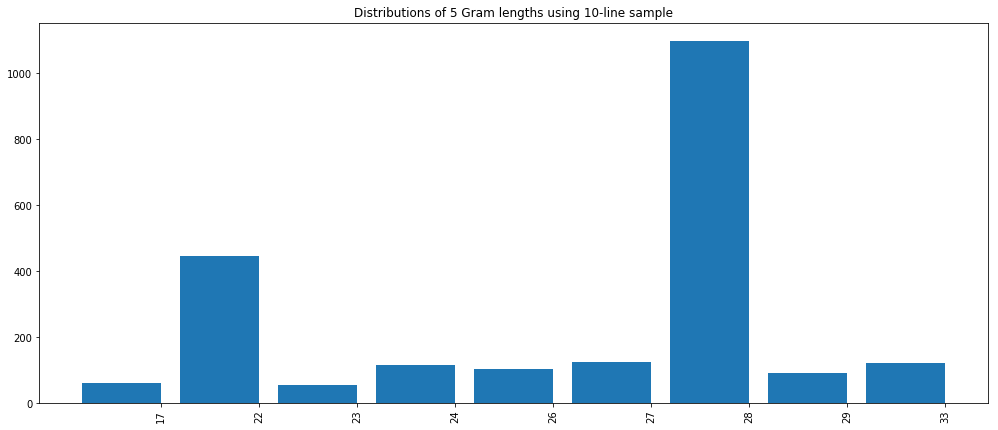

In [70]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distributions_10lines.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths using 10-line sample")
pl.show()

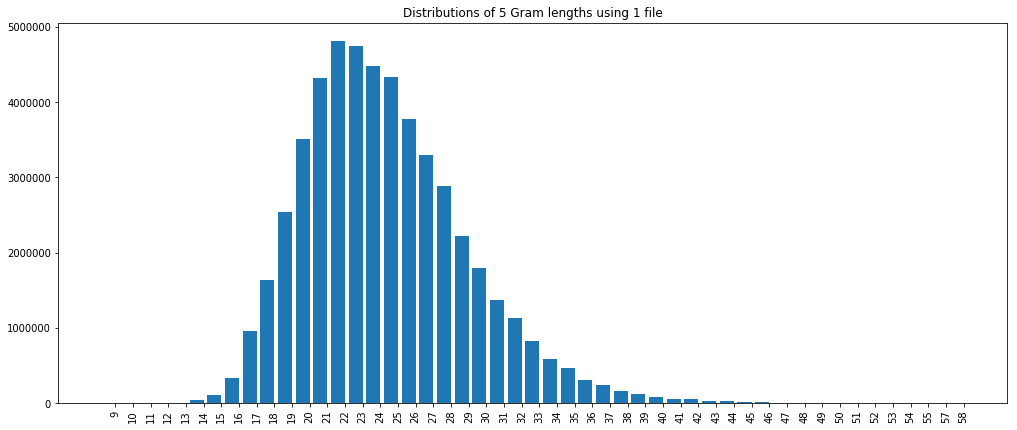

In [96]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distributions_1file.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths using 1 file")
pl.show()

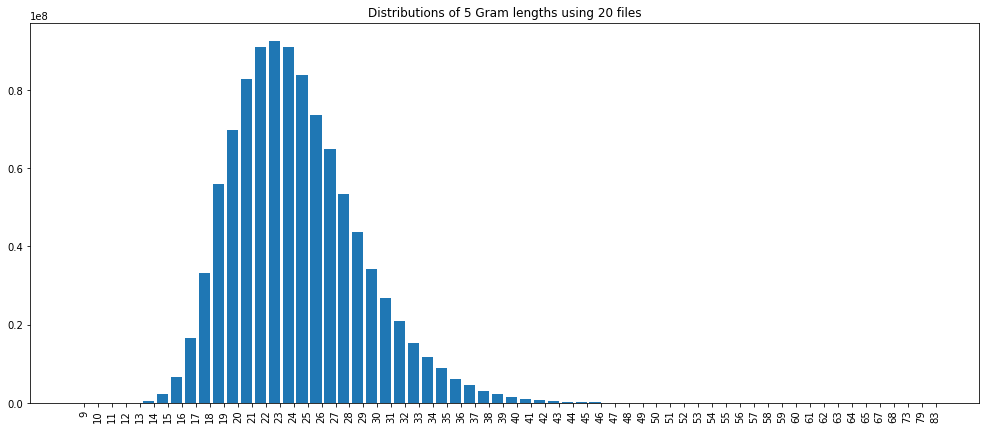

In [71]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distributions_20files.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths using 20 files")
pl.show()

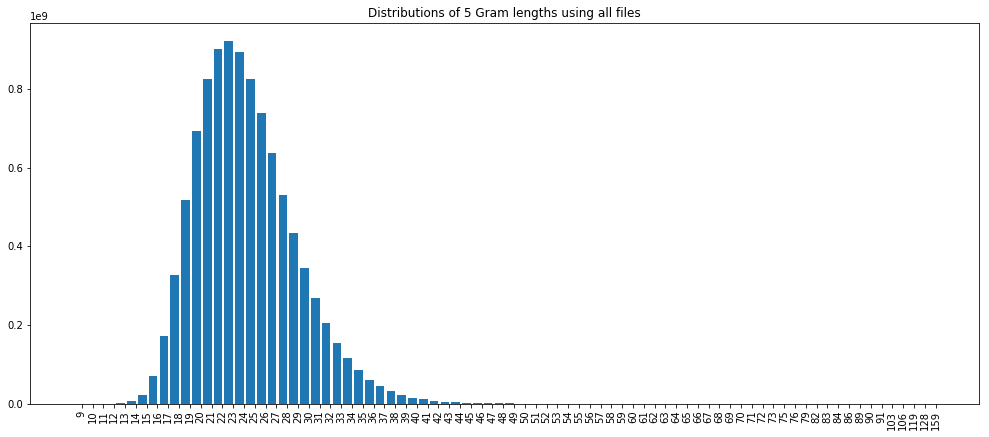

In [72]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distributions_full.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([int(X),int(Y)])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=0.8
ax.bar(range(len(items[0])), items[1], width=width)
ax.set_xticks(np.arange(len(items[0])) + width/2)
ax.set_xticklabels(items[0], rotation=90)



pl.title("Distributions of 5 Gram lengths using all files")
pl.show()

### HW5.6.2 - OPTIONAL: log-log plots (PHASE 2)

Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law

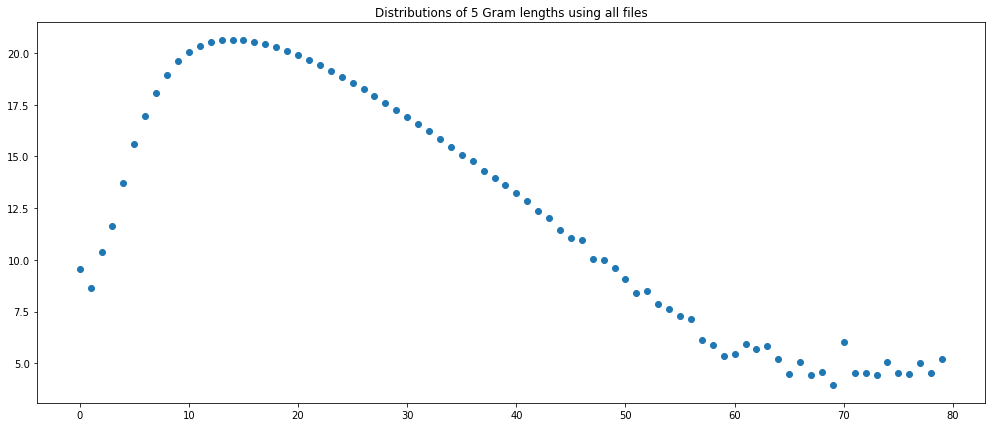

In [16]:
%matplotlib inline
import numpy as np
import pylab as pl

results_A = []
for line in open("distributions_full.txt").readlines():
    line = line.strip()
    X,Y = line.split("\t")
    results_A.append([np.log(int(X)),np.log(int(Y))])

items = (np.array(results_A)[::-1].T)
fig = pl.figure(figsize=(17,7))
ax = pl.subplot(111)
width=1
ax.scatter(range(len(items[0])), items[1])
#ax.set_xticks(np.arange(len(items[0])) + width)
#ax.set_xticklabels(items[0], rotation=90)

pl.title("Distributions of 5 Gram lengths using all files")
pl.show()

# HW5.7 - Synonym detection over 2Gig of Data with extra Preprocessing steps (HW5.3-5 plus some preprocessing)   

For the remainder of this assignment please feel free to eliminate stop words from your analysis (see stopWords in the cell below)

__A large subset of the Google n-grams dataset as was described above__

For each HW 5.6 - 5.7.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with your system.

In this part of the assignment we will focus on developing methods for detecting synonyms, using the Google 5-grams dataset. At a high level:


1. remove stopwords
2. get 10,000 most frequent
3. get 1000 (9001-10000) features
3. build stripes

To accomplish this you must script two main tasks using MRJob:


__TASK (1)__ Build stripes for the most frequent 10,000 words using cooccurence information based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


__TASK (2)__ Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.


For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

In [73]:
stopwords =  ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 
              'ourselves', 'you', 'your', 'yours', 'yourself', 
              'yourselves', 'he', 'him', 'his', 'himself', 'she', 
              'her', 'hers', 'herself', 'it', 'its', 'itself', 
              'they', 'them', 'their', 'theirs', 'themselves', 
              'what', 'which', 'who', 'whom', 'this', 'that', 
              'these', 'those', 'am', 'is', 'are', 'was', 'were', 
              'be', 'been', 'being', 'have', 'has', 'had', 'having', 
              'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 
              'but', 'if', 'or', 'because', 'as', 'until', 'while', 
              'of', 'at', 'by', 'for', 'with', 'about', 'against', 
              'between', 'into', 'through', 'during', 'before', 
              'after', 'above', 'below', 'to', 'from', 'up', 'down', 
              'in', 'out', 'on', 'off', 'over', 'under', 'again', 
              'further', 'then', 'once', 'here', 'there', 'when', 
              'where', 'why', 'how', 'all', 'any', 'both', 'each', 
              'few', 'more', 'most', 'other', 'some', 'such', 'no', 
              'nor', 'not', 'only', 'own', 'same', 'so', 'than', 
              'too', 'very', 's', 't', 'can', 'will', 'just', 
              'don', 'should', 'now']

__STEP 1: Code and Steps for Preprocessing__

In [74]:
# Remove stop words, get 10,000 most frequent words

# Find top 10,000 most frequent words
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'ten_thousand_1')
!hadoop fs -rm -r {OUTPUT_PATH}

!python mostFrequentWords_v2.py \
        -r hadoop hdfs://{TEST_1}/* \
        --output-dir={OUTPUT_PATH} \
        --no-output


rm: `/user/seungham/ten_thousand_1': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords_v2.seungham.20180307.060735.104158
Copying local files to hdfs:///user/seungham/tmp/mrjob/mostFrequentWords_v2.seungham.20180307.060735.104158/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob602455303466969888.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service ad

In [75]:
!hadoop fs -cat {OUTPUT_PATH}/* | head -n 10000 > ten_thousand_1.dat

cat: Unable to write to output stream.


In [76]:
# Find top 10,000 most frequent words
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'ten_thousand_20')
!hadoop fs -rm -r {OUTPUT_PATH}

!python mostFrequentWords_v2.py \
        -r hadoop hdfs://{TEST_20}/* \
        --output-dir={OUTPUT_PATH} \
        --no-output


rm: `/user/seungham/ten_thousand_20': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords_v2.seungham.20180307.060939.324052
Copying local files to hdfs:///user/seungham/tmp/mrjob/mostFrequentWords_v2.seungham.20180307.060939.324052/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob1685292376185222474.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline service 

In [77]:
!hadoop fs -cat {OUTPUT_PATH}/* | head -n 10000 > ten_thousand_20.dat

cat: Unable to write to output stream.


In [78]:
!cat ten_thousand_20.dat | head -n 10

96842	"one"	
78007	"would"	
61528	"may"	
54461	"time"	
47887	"could"	
43156	"made"	
41150	"two"	
38056	"first"	
37980	"much"	
35334	"new"	
cat: write error: Broken pipe


In [79]:
!cat ten_thousand_20.dat | tail -n 10

118	"anxiously"	
118	"culmination"	
118	"viewing"	
118	"refute"	
118	"superstitious"	
118	"synod"	
118	"airway"	
118	"pancreas"	
118	"sterile"	
118	"nigh"	


In [80]:
# Find top 10,000 most frequent words
OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'ten_thousand_FULL')
!hadoop fs -rm -r {OUTPUT_PATH}

!python mostFrequentWords_v2.py \
        -r hadoop hdfs://{FULL_DATA}/* \
        --output-dir={OUTPUT_PATH} \
        --no-output


rm: `/user/seungham/ten_thousand_FULL': No such file or directory
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/mostFrequentWords_v2.seungham.20180307.061222.719462
Copying local files to hdfs:///user/seungham/tmp/mrjob/mostFrequentWords_v2.seungham.20180307.061222.719462/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7579177207247463440.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/timeline/
  Connecting to ResourceManager at rm-ia.s3s.altiscale.com/10.251.255.108:8032
  Connecting to Application History server at rm-ia.s3s.altiscale.com/10.251.255.108:10200
  Timeline servic

Removing temp directory /tmp/mostFrequentWords_v2.seungham.20180307.061222.719462...


In [81]:
!hadoop fs -cat {OUTPUT_PATH}/* | head -n 10000 > ten_thousand_FULL.dat

cat: Unable to write to output stream.


In [83]:
!cat ten_thousand_FULL.dat | head -n 10

960248	"one"	
774470	"would"	
607952	"may"	
538152	"time"	
471057	"could"	
426271	"made"	
412427	"two"	
378558	"much"	
377105	"first"	
345266	"new"	
cat: write error: Broken pipe


In [84]:
!cat ten_thousand_FULL.dat | tail -n 10

1159	"persuading"	
1159	"aspire"	
1159	"wording"	
1159	"fantasy"	
1158	"simon"	
1158	"consciously"	
1158	"iodine"	
1158	"grandson"	
1157	"detention"	
1157	"danish"	


In [85]:
# Also create features
!cat ten_thousand_1.dat |tail -n 999 > features_1.dat
!cat ten_thousand_20.dat |tail -n 999 > features_20.dat
!cat ten_thousand_FULL.dat |tail -n 999 > features_FULL.dat

**We now have files with 10K words => `ten_thousand_*.dat` AND
features with words from 9,001 to 10,000 in => `features_*.dat` **

In [86]:
### Some extra preprocessing to load files faster
import json
files = ['features_1','features_20', 'features_FULL', 'ten_thousand_1', 'ten_thousand_20','ten_thousand_FULL']
for fileName in files:
    with open(fileName+'.dat') as f:
        words = []
        for line in f:
            word = line.split("\t")[1].strip('"')
            words.append(word)
    with open(fileName+'.json', 'w') as outfile:
        json.dump(words, outfile)

__STEP 2: MODIFY BUILD STRIPES TO ONLY INCLUDE 10K words with 1K as FEATURES__

In [87]:
%%writefile buildStripes_stopwords_1.py
#!~/opt/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools

class MRbuildStripes(MRJob):
    
    SORT_VALUES = True
    
    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper,
                reducer=self.reducer,
                jobconf = {
                    "mapreduce.job.reduces": "64",
                    "mapreduce.job.maps": "64",
#                     "SORT_VALUES":True
                }
            ),
            MRStep(
                reducer=self.reducer_2,
                jobconf = {
                    "mapreduce.job.reduces": "1",
                    "SORT_VALUES":True
                }
            )
            
        ]
    
    def mapper_init(self):
        self.idx = 9001  # To define when feature set starts
        self.filename = 'ten_thousand_1.json'
        
        self.top_words = []
        self.features = []
        with open(self.filename, 'r') as infile:
            self.top_words = json.loads(infile.read())
            self.features =self.top_words[self.idx:]

    def mapper(self, _, line):
        fields = line.lower().strip("\n").split("\t")
        words = fields[0].split(" ")
        occurrence_count = int(fields[1])
        filtered_words = [word.decode('utf-8', 'ignore') for word in words if word.decode('utf-8', 'ignore') in self.top_words]
        for subset in itertools.combinations(sorted(set(filtered_words)), 2):
            if subset[0] in self.top_words and subset[1] in self.features:
                yield subset[0], (subset[1], occurrence_count)
            if subset[1] in self.top_words and subset[0] in self.features:
                yield subset[1], (subset[0], occurrence_count)
    
    def reducer(self, word, occurrence_counts):
        stripe = {}
        for other_word, occurrence_count in occurrence_counts:
            stripe[other_word] = stripe.get(other_word,0)+occurrence_count
        yield word, stripe
    
    def reducer_2(self, key, values):
        yield str(key), list(values)[0]
        
if __name__ == '__main__':
    MRbuildStripes.run()

Writing buildStripes_stopwords_1.py


### HW5.7.1 Running on 1 file

In [88]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python buildStripes_stopwords_1.py \
        -r hadoop hdfs://{TEST_1}/* \
        --file ten_thousand_1.json  \
        --output-dir={OUTPUT_PATH} \
        --no-output

    

18/03/07 06:16:52 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/seungham/.Trash/Current
Using configs in /home/seungham/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripes_stopwords_1.seungham.20180307.061653.177484
Copying local files to hdfs:///user/seungham/tmp/mrjob/buildStripes_stopwords_1.seungham.20180307.061653.177484/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob4624740827838191211.jar tmpDir=null
  Timeline service address: http://rm-ia

Removing temp directory /tmp/buildStripes_stopwords_1.seungham.20180307.061653.177484...

real	2m56.872s
user	0m51.472s
sys	0m2.523s


In [ ]:
####NOT USED, BUT KEEP JUST IN CASE
import os
from os import listdir
from os.path import isfile, join

def totalOrderSort(myPath, outFileName):
    wordsFiles = {}
    words = []
    for f in listdir(myPath):
        if isfile(join(myPath,f)) and "part" in f:
            with open(join(myPath,f)) as openFile:
                word = f.readline().split("\t")[0]
                words.append(word)
                wordsFiles[word]= join(mypath,f)
    print wordsFiles
    print words

In [90]:
# Look at data
# !hadoop fs -cat {OUTPUT_PATH}/*
# Save into file for processing
!hadoop fs -cat {OUTPUT_PATH}/* > google_stripes_1

In [91]:
!cat google_stripes_1 | head

"abdominal"	{"thoracic": 80}
"abilities"	{"precarious": 51}
"ability"	{"navigate": 78, "lacked": 60}
"able"	{"accustom": 270, "illuminate": 67, "invoke": 53, "broaden": 256, "sage": 67, "extricate": 146, "prolong": 78, "practitioner": 41}
"ablest"	{"thinkers": 59}
"abolished"	{"aftermath": 64}
"absence"	{"rainfall": 76, "receptors": 43, "prolong": 87, "preside": 272, "guiding": 64, "toxicity": 52}
"absolute"	{"ratings": 116, "antagonism": 89, "conductivity": 94}
"absolutely"	{"converts": 142, "insensible": 43}
"absorb"	{"appreciable": 92}
cat: write error: Broken pipe


In [92]:
!cat google_stripes_1 | tail

"ye"	{"trod": 95}
"year"	{"rushes": 50, "inhabitant": 79, "darkened": 41, "portugal": 78, "amounting": 86}
"years"	{"intervening": 51, "jesuit": 42, "companionship": 52, "veteran": 54, "schooling": 702, "avowed": 54, "accomplishments": 54, "servitude": 190, "peking": 49, "uninterrupted": 87, "upwards": 97}
"yellow"	{"honey": 52, "sleeves": 59}
"yet"	{"dexterity": 50, "incarnation": 59, "digging": 42, "admirer": 64, "lacks": 48, "kid": 52}
"yoke"	{"emancipation": 68}
"york"	{"designer": 180, "norway": 63, "reporting": 280, "borough": 542, "patriots": 46, "sydney": 284, "trains": 65, "protector": 65, "guys": 62}
"young"	{"conceit": 52, "gallant": 75, "diarrhea": 51, "starved": 54}
"youth"	{"ropes": 49, "frustrated": 54}
"zinc"	{"dissolving": 64}


In [15]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python invertedIndex_v2.py \
        -r hadoop google_stripes_1 \
        --output-dir={OUTPUT_PATH} \
        --no-output


18/03/06 15:38:53 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/lteo01/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/lteo01/.Trash/Current
Using configs in /home/lteo01/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex_s.lteo01.20180306.153854.119645
Copying local files to hdfs:///user/lteo01/tmp/mrjob/invertedIndex_s.lteo01.20180306.153854.119645/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob198206904659061463.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v1/t

In [17]:
# Save into file for processing
!hadoop fs -cat {OUTPUT_PATH}/* > google_index_1
!cat google_index_1 | head

"ab"	[["cannot", 6], ["cd", 1], ["chord", 2], ["equal", 4], ["lines", 2], ["piece", 3], ["quantity", 3], ["university", 12]]
"abnormalities"	[["associated", 3], ["b", 3], ["found", 17], ["indicate", 2], ["may", 55], ["organs", 1], ["patients", 12], ["reproductive", 1], ["result", 2], ["show", 5], ["usually", 3], ["vitamin", 1]]
"absolve"	[["citizens", 1], ["english", 14], ["lord", 7], ["may", 55], ["obligations", 1], ["right", 13], ["thee", 2], ["would", 47]]
"absorbing"	[["beautiful", 4], ["become", 12], ["capable", 5], ["case", 11], ["cost", 2], ["far", 15], ["france", 1], ["interest", 10], ["light", 6], ["may", 55], ["molecules", 1], ["still", 8]]
"abundantly"	[["apparently", 2], ["become", 12], ["clear", 1], ["consumption", 1], ["exemplified", 1], ["found", 17], ["naked", 1], ["supplied", 2]]
"abyss"	[["distress", 1], ["lead", 7], ["nothing", 6], ["occupied", 1], ["previous", 4], ["separates", 2], ["ultimately", 2], ["us", 21]]
"ac"	[["angle", 4], ["circuit", 2], ["components", 1],

In [93]:
##########################################################
# Pretty print systems tests for generating Inverted Index
##########################################################

import json

for i in range(1,2):
    print "—"*100
    print "Systems test ",i," - Inverted Index"
    print "—"*100  
    with open("google_index_"+str(i)+"","r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            word,stripe = line.split("\t")
            stripe = json.loads(stripe)
            stripe.extend([["",""] for _ in xrange(3 - len(stripe))])

            print "{0:>16} |{1:>16} |{2:>16} |{3:>16}".format((word), 
                stripe[0][0]+" "+str(stripe[0][1]), stripe[1][0]+" "+str(stripe[1][1]), stripe[2][0]+" "+str(stripe[2][1]))

————————————————————————————————————————————————————————————————————————————————————————————————————
Systems test  1  - Inverted Index
————————————————————————————————————————————————————————————————————————————————————————————————————
            "ab" |        cannot 6 |            cd 1 |         chord 2
 "abnormalities" |    associated 3 |             b 3 |        found 17
       "absolve" |      citizens 1 |      english 14 |          lord 7
     "absorbing" |     beautiful 4 |       become 12 |       capable 5
    "abundantly" |    apparently 2 |       become 12 |         clear 1
         "abyss" |      distress 1 |          lead 7 |       nothing 6
            "ac" |         angle 4 |       circuit 2 |    components 1
    "accusation" |          face 5 |          laid 3 |         make 28
      "accustom" |          able 8 |        change 7 |        could 25
        "acetic" |          acid 4 |         acids 2 |           add 2
     "acquitted" |         blame 1 |          end 10 |

    "resumption" |        marked 3 |       partial 2 |       payment 3
   "retardation" |   association 3 |     committee 3 |      criteria 1
     "retention" |     cognitive 2 |      movement 5 |        rights 3
       "rethink" |       beliefs 1 |       demands 2 |          felt 4
      "retiring" |        active 4 |    approached 1 |         court 7
     "retreated" |         gave 10 |         long 23 |         ocean 2
    "retrospect" |       affairs 3 |       inquiry 1 |       medical 1
        "revise" |       appoint 2 |         asked 1 |    commission 2
      "rhodesia" |  constitution 4 |   established 2 |       federal 6
         "rican" |         black 3 |     character 6 |       enables 3
      "richness" |      anywhere 1 |          find 9 |     increased 4
     "righteous" |         alike 1 |          dead 2 |         dwell 1
         "riots" |      communal 1 |       country 8 |manifestations 2
         "ropes" |         angle 4 |        around 9 |         case 11
      

In [11]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python similarity_cosine_sort.py \
        -r hadoop google_index_1 \
        --output-dir={OUTPUT_PATH} \
        --no-output
            

18/03/07 21:44:48 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/.Trash/Current
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity_cosine_sort.stassyvichev.20180307.214449.482542
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/similarity_cosine_sort.stassyvichev.20180307.214449.482542/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6408989912093200435.jar tmpDir=null
  Timeline service a

Removing temp directory /tmp/similarity_cosine_sort.stassyvichev.20180307.214449.482542...

real	11m38.173s
user	0m49.310s
sys	0m2.536s


In [12]:
# Save into file for processing
!hadoop fs -cat {OUTPUT_PATH}/* > google_similarities_1
!head google_similarities_1

1.0 	 ["abdominal - artery",1.0,1.0,1.0,1.0]	
1.0 	 ["abdominal - trachea",1.0,1.0,1.0,1.0]	
1.0 	 ["abilities - imperfect",1.0,1.0,1.0,1.0]	
1.0 	 ["abilities - relates",1.0,1.0,1.0,1.0]	
1.0 	 ["abilities - seal",1.0,1.0,1.0,1.0]	
1.0 	 ["abilities - subsistence",1.0,1.0,1.0,1.0]	
1.0 	 ["ability - beginning",1.0,1.0,1.0,1.0]	
1.0 	 ["ability - decades",1.0,1.0,1.0,1.0]	
1.0 	 ["ability - declined",1.0,1.0,1.0,1.0]	
1.0 	 ["ability - invention",1.0,1.0,1.0,1.0]	


In [ ]:
############################################
# Pretty print systems tests
# Note: adjust print formatting if you need to
############################################

import json
for i in range(1,2):
    print '—'*110
    print "Systems test ",i," - Similarity measures"
    print '—'*110
    print "{0:>21} | {1:>15} |{2:>15} | {3:>15} | {4:>15} | {5:>15}".format("pair", 
        "cosine", "jaccard", "overlap", "dice", "average")
    print '-'*110

    with open("google_similarities_"+str(i),"r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            avg,stripe = line.split("\t")
            stripe = json.loads(stripe)
            
            print "{0:>21} | {1:>15f} |{2:>15f} |{3:>15f} | {4:>15f} | {5:>15f} ".format(stripe[0], 
                float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]), float(avg))

### HW5.7.2 Running on 20 test files

In [23]:
%%writefile buildStripes_stopwords_20.py
#!~/opt/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools

class MRbuildStripes(MRJob):
    
    SORT_VALUES = True
    
    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper,
                reducer=self.reducer,
                jobconf = {
                    "mapreduce.job.reduces": "64",
                    "mapreduce.job.maps": "64",
#                     "SORT_VALUES":True
                }
            ),
            MRStep(
                reducer=self.reducer_2,
                jobconf = {
                    "mapreduce.job.reduces": "1",
                    "SORT_VALUES":True
                }
            )
            
        ]
    
    def mapper_init(self):
        self.idx = 9001  # To define when feature set starts
        self.filename = 'ten_thousand_20.json'
        
        self.top_words = []
        self.features = []
        #with open('features_20.json', 'r') as infile:
        #    self.features = json.loads(infile.read())
        with open(self.filename, 'r') as infile:
            self.top_words = json.loads(infile.read())
            self.features =self.top_words[self.idx:]

    def mapper(self, _, line):
        fields = line.lower().strip("\n").split("\t")
        words = fields[0].split(" ")
        occurrence_count = int(fields[1])
        filtered_words = [word.decode('utf-8', 'ignore') for word in words if word.decode('utf-8', 'ignore') in self.top_words]
        for subset in itertools.combinations(sorted(set(filtered_words)), 2):
            if subset[0] in self.top_words and subset[1] in self.features:
                yield subset[0], (subset[1], occurrence_count)
            if subset[1] in self.top_words and subset[0] in self.features:
                yield subset[1], (subset[0], occurrence_count)
    
    def reducer(self, word, occurrence_counts):
        stripe = {}
        for other_word, occurrence_count in occurrence_counts:
            stripe[other_word] = stripe.get(other_word,0)+occurrence_count
        yield word, stripe
    
    def reducer_2(self, key, values):
        yield str(key), list(values)[0]
        
if __name__ == '__main__':
    MRbuildStripes.run()

Overwriting buildStripes_stopwords_20.py


In [24]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python buildStripes_stopwords_20.py \
        -r hadoop hdfs://{TEST_20}/* \
        --file ten_thousand_20.json \
        --output-dir={OUTPUT_PATH} \
        --no-output
            



18/03/06 15:53:11 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/lteo01/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/lteo01/.Trash/Current
Using configs in /home/lteo01/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripes_stopwords_20.lteo01.20180306.155312.676147
Copying local files to hdfs:///user/lteo01/tmp/mrjob/buildStripes_stopwords_20.lteo01.20180306.155312.676147/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob7797187335133637485.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altis

Removing temp directory /tmp/buildStripes_stopwords_20.lteo01.20180306.155312.676147...

real	7m27.141s
user	0m51.520s
sys	0m2.541s


In [25]:
!hadoop fs -cat {OUTPUT_PATH}/* > google_stripes_20

In [26]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python invertedIndex_v2.py \
        -r hadoop google_stripes_20 \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/03/06 16:00:43 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/lteo01/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/lteo01/.Trash/Current
Using configs in /home/lteo01/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex_v2.lteo01.20180306.160044.358309
Copying local files to hdfs:///user/lteo01/tmp/mrjob/invertedIndex_v2.lteo01.20180306.160044.358309/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob9036766339060416359.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v

In [27]:
!hadoop fs -cat {OUTPUT_PATH}/* > google_index_20

In [13]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python similarity_cosine_sort.py \
        -r hadoop google_index_20 \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/03/07 22:03:22 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/.Trash/Current
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity_cosine_sort.stassyvichev.20180307.220323.562566
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/similarity_cosine_sort.stassyvichev.20180307.220323.562566/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob407702235895612287.jar tmpDir=null
  Timeline service ad

   map 100% reduce 72%
   map 100% reduce 78%
   map 100% reduce 81%
   map 100% reduce 85%
   map 100% reduce 88%
   map 100% reduce 89%
   map 100% reduce 90%
   map 100% reduce 91%
   map 100% reduce 92%
   map 100% reduce 94%
   map 100% reduce 95%
   map 100% reduce 96%
   map 100% reduce 97%
   map 100% reduce 98%
   map 100% reduce 99%
   map 100% reduce 100%
  Job job_1509050304403_29211 completed successfully
  Output directory: hdfs:///user/stassyvichev/tests
Counters: 52
	File Input Format Counters 
		Bytes Read=352968031
	File Output Format Counters 
		Bytes Written=308970586
	File System Counters
		FILE: Number of bytes read=49867546
		FILE: Number of bytes written=167022056
		FILE: Number of large read operations=0
		FILE: Number of read operations=0
		FILE: Number of write operations=0
		HDFS: Number of bytes read=352994015
		HDFS: Number of bytes written=308970586
		HDFS: Number of large read operations=0
		HDFS: Number of read operations=459
		HDFS: Number of write ope

In [14]:
!hadoop fs -cat {OUTPUT_PATH}/* > google_similarities_2


In [15]:
!head google_similarities_2
!tail google_similarities_2

1.0 	 ["abandon - participating",1.0,1.0,1.0,1.0]	
1.0 	 ["abnormalities - subset",1.0,1.0,1.0,1.0]	
1.0 	 ["abstain - enlarge",1.0,1.0,1.0,1.0]	
1.0 	 ["abstain - opposing",1.0,1.0,1.0,1.0]	
1.0 	 ["accelerated - influencing",1.0,1.0,1.0,1.0]	
1.0 	 ["accord - coincidence",1.0,1.0,1.0,1.0]	
1.0 	 ["accumulate - squeezed",1.0,1.0,1.0,1.0]	
1.0 	 ["acquaintances - surpassed",1.0,1.0,1.0,1.0]	
1.0 	 ["adherents - lifetime",1.0,1.0,1.0,1.0]	
1.0 	 ["adjustments - gratified",1.0,1.0,1.0,1.0]	
0.04 	 ["tendency - test",0.0351020408163,0.0204081632653,0.04,0.04]	
0.04 	 ["tendency - tissue",0.0351020408163,0.0204081632653,0.04,0.04]	
0.04 	 ["tendency - unable",0.0351020408163,0.0204081632653,0.04,0.04]	
0.04 	 ["tendency - virtue",0.0351020408163,0.0204081632653,0.04,0.04]	
0.04 	 ["test - virtue",0.0351020408163,0.0204081632653,0.04,0.04]	
0.04 	 ["test - wrote",0.0351020408163,0.0204081632653,0.04,0.04]	
0.04 	 ["tissue - virtue",0.0351020408163,0.0204081632653,0.04,0.04]	
0.04 	 ["unable

In [ ]:
############################################
# Pretty print systems tests
# Note: adjust print formatting if you need to
############################################

import json
for i in range(2,3):
    print '—'*110
    print "Systems test ",i," - Similarity measures"
    print '—'*110
    print "{0:>15} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
    "average", "pair", "cosine", "jaccard", "overlap", "dice")
    print '-'*110

    with open("google_similarities_"+str(i),"r") as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            avg,stripe = line.split("\t")
            stripe = json.loads(stripe)
            
            print "{0:>15f} |{1:>15} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(float(avg),
                stripe[0], float(stripe[1]), float(stripe[2]), float(stripe[3]), float(stripe[4]))

### HW5.7.3 Running the full dataset on Altiscale

Please contact the TAs for approval after obtaining results from 5.7.2. We have ran into issues in the past where the clusters froze because people did not test their code on a smaller dataset.

In [30]:
%%writefile buildStripes_stopwords.py
#!~/opt/anaconda2/bin/python
# -*- coding: utf-8 -*-

from __future__ import division
import re
import mrjob
import json
from mrjob.protocol import RawProtocol
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools

class MRbuildStripes(MRJob):
    
    SORT_VALUES = True
    
    def steps(self):
        return [
            MRStep(
                mapper_init=self.mapper_init,
                mapper=self.mapper,
                reducer=self.reducer,
                jobconf = {
                    "mapreduce.job.reduces": "64",
                    "mapreduce.job.maps": "64",
#                     "SORT_VALUES":True
                }
            ),
            MRStep(
                reducer=self.reducer_2,
                jobconf = {
                    "mapreduce.job.reduces": "1",
                    "SORT_VALUES":True
                }
            )
            
        ]
    
    def mapper_init(self):
        self.idx = 9001  # To define when feature set starts
        self.filename = 'ten_thousand_FULL.json'
        
        self.top_words = []
        self.features = []
        #with open('features_20.json', 'r') as infile:
        #    self.features = json.loads(infile.read())
        with open(self.filename, 'r') as infile:
            self.top_words = json.loads(infile.read())
            self.features =self.top_words[self.idx:]

    def mapper(self, _, line):
        fields = line.lower().strip("\n").split("\t")
        words = fields[0].split(" ")
        occurrence_count = int(fields[1])
        filtered_words = [word.decode('utf-8', 'ignore') for word in words if word.decode('utf-8', 'ignore') in self.top_words]
        for subset in itertools.combinations(sorted(set(filtered_words)), 2):
            if subset[0] in self.top_words and subset[1] in self.features:
                yield subset[0], (subset[1], occurrence_count)
            if subset[1] in self.top_words and subset[0] in self.features:
                yield subset[1], (subset[0], occurrence_count)
    
    def reducer(self, word, occurrence_counts):
        stripe = {}
        for other_word, occurrence_count in occurrence_counts:
            stripe[other_word] = stripe.get(other_word,0)+occurrence_count
        yield word, stripe
    
    def reducer_2(self, key, values):
        yield str(key), list(values)[0]
        
if __name__ == '__main__':
    MRbuildStripes.run()



Overwriting buildStripes_stopwords.py


In [31]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python buildStripes_stopwords.py \
        -r hadoop hdfs://{FULL_DATA}/* \
        --file ten_thousand_FULL.json \
        --output-dir={OUTPUT_PATH} \
        --no-output
            



18/03/06 16:09:25 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/lteo01/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/lteo01/.Trash/Current
Using configs in /home/lteo01/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/buildStripes_stopwords.lteo01.20180306.160925.905278
Copying local files to hdfs:///user/lteo01/tmp/mrjob/buildStripes_stopwords.lteo01.20180306.160925.905278/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob3862403407545034719.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.c

Removing temp directory /tmp/buildStripes_stopwords.lteo01.20180306.160925.905278...

real	30m3.979s
user	0m55.912s
sys	0m2.750s


In [33]:
!hadoop fs -cat {OUTPUT_PATH}/* > google_stripes_FULL

#### Stats for building stripes

> Cluster size: 64 mappers & 64 reducers for step 1, 65 mappers and 1 reducer for step 2.

> Time taken: 30 mins


In [34]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python invertedIndex_v2.py \
        -r hadoop google_stripes_FULL \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/03/06 16:43:40 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/lteo01/tests' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/lteo01/.Trash/Current
Using configs in /home/lteo01/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/invertedIndex_v2.lteo01.20180306.164340.912983
Copying local files to hdfs:///user/lteo01/tmp/mrjob/invertedIndex_v2.lteo01.20180306.164340.912983/files/...
Running step 1 of 1...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob6369264445573276562.jar tmpDir=null
  Timeline service address: http://rm-ia.s3s.altiscale.com:8188/ws/v

In [35]:
!hadoop fs -cat {OUTPUT_PATH}/* > google_index_FULL

#### Stats for inverted index

> Cluster size: 2 mappers & 1 reducer for step 1.

> Time taken: 1 min

In [16]:
# Run in Hadoop

OUTPUT_PATH = os.path.join(OUTPUT_PATH_BASE,'tests_similarities_full')
!hadoop fs -rm -r {OUTPUT_PATH}

!time python similarity_cosine_sort.py \
        -r hadoop google_index_FULL \
        --output-dir={OUTPUT_PATH} \
        --no-output

18/03/07 22:30:35 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 5760 minutes, Emptier interval = 360 minutes.
Moved: 'hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/tests_similarities_full' to trash at: hdfs://nn-ia.s3s.altiscale.com:8020/user/stassyvichev/.Trash/Current
Using configs in /home/stassyvichev/.mrjob.conf
Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 2.7.3
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar
Creating temp directory /tmp/similarity_cosine_sort.stassyvichev.20180307.223036.522395
Copying local files to hdfs:///user/stassyvichev/tmp/mrjob/similarity_cosine_sort.stassyvichev.20180307.223036.522395/files/...
Running step 1 of 2...
  packageJobJar: [] [/opt/hadoop-2.7.3/share/hadoop/tools/lib/hadoop-streaming-2.7.3.jar] /tmp/streamjob10540228423058070.jar tmpDir=null
  Ti

  Output directory: hdfs:///user/stassyvichev/tests_similarities_full
Counters: 52
	File Input Format Counters 
		Bytes Read=2812891118
	File Output Format Counters 
		Bytes Written=2134539056
	File System Counters
		FILE: Number of bytes read=391244366
		FILE: Number of bytes written=1230346220
		FILE: Number of large read operations=0
		FILE: Number of read operations=0
		FILE: Number of write operations=0
		HDFS: Number of bytes read=2812917102
		HDFS: Number of bytes written=2134539056
		HDFS: Number of large read operations=0
		HDFS: Number of read operations=459
		HDFS: Number of write operations=50
	Intermediate Reducer Counters
		Calls=23
	Job Counters 
		Killed map tasks=3
		Killed reduce tasks=4
		Launched map tasks=131
		Launched reduce tasks=27
		Rack-local map tasks=131
		Total megabyte-milliseconds taken by all map tasks=9554598912
		Total megabyte-milliseconds taken by all reduce tasks=5209356800
		Total time spent by all map tasks (ms)=6220442
		Total time spent by all 

In [17]:
# !hadoop fs -cat {OUTPUT_PATH}/* > google_similarities_3_unsorted
# !cat google_similarities_3_unsorted | head
!hadoop fs -cat {OUTPUT_PATH}/* > google_similarities_3

#### Stats for calculating similarities

> Cluster size: 128 mappers & 128 reducers for step 1, 130 mappers (not doing anything) and 25 reducer for step 2.

> Time taken: 13 mins

In [18]:
!head google_similarities_3
!tail google_similarities_3

0.956447868181 	 ["may - one",0.953774587141,0.915662650602,0.987012987013,0.955974842767]	
0.951629843601 	 ["one - time",0.949503752458,0.906438631791,0.989023051592,0.95092348285]	
0.933887308268 	 ["one - well",0.931337617093,0.873620862588,0.985294117647,0.932548179872]	
0.927321037257 	 ["one - would",0.925135014996,0.861445783133,0.986206896552,0.925566343042]	
0.927105069301 	 ["angeles - los",0.916892675308,0.863636363636,0.95,0.926829268293]	
0.922326409356 	 ["first - one",0.921185121828,0.851814516129,0.99062133646,0.919978225367]	
0.915554311135 	 ["may - time",0.899342604528,0.844221105528,0.922063666301,0.91553133515]	
0.915046978761 	 ["may - well",0.902101919714,0.843017329256,0.935520361991,0.91482300885]	
0.908719205473 	 ["time - would",0.894846793156,0.832304526749,0.929885057471,0.908478382931]	
0.907880719098 	 ["may - would",0.895398622539,0.830612244898,0.935632183908,0.907469342252]	
0.04 	 ["warrant - whatsoever",0.0351020408163,0.0204081632653,0.04,0.04]	
0.

#### Pretty print results
NOTE: depending on how you processed the stop words your results may differ from the table provided. 

In [19]:
print "\nTop/Bottom 20 results - Similarity measures - sorted by average"
print "(From the entire data set)"
print '—'*117
print "{0:>30} |{1:>15} |{2:>15} |{3:>15} |{4:>15} |{5:>15}".format(
        "pair", "cosine", "jaccard", "overlap", "dice", "average")
print '-'*117
import json
with open("google_similarities_3","r") as f:
    sortedSims = f.readlines()
    for stripe in sortedSims[:20]:
        cosine, other,_ = stripe.split("\t")
        data = json.loads(other)
        print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
            data[0], float(cosine.strip()), float(data[2]), float(data[3]), float(data[4]), float(data[1]) )

    print '—'*117

    for stripe in sortedSims[-20:]:
        cosine, other,_ = stripe.split("\t")
        data = json.loads(other)
        print "{0:>30} |{1:>15f} |{2:>15f} |{3:>15f} |{4:>15f} |{5:>15f}".format(
            data[0], float(cosine.strip()), float(data[2]), float(data[3]), float(data[4]), float(data[1]) )



Top/Bottom 20 results - Similarity measures - sorted by average
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                     may - one |       0.956448 |       0.915663 |       0.987013 |       0.955975 |       0.953775
                    one - time |       0.951630 |       0.906439 |       0.989023 |       0.950923 |       0.949504
                    one - well |       0.933887 |       0.873621 |       0.985294 |       0.932548 |       0.931338
                   one - would |       0.927321 |       0.861446 |       0.986207 |       0.925566 |       0.925135
                 angeles - los |       0.927105 |       0.863636 |       0.950000 |       0.

In [ ]:
Top/Bottom 20 results - Similarity measures - sorted by cosine
(From the entire data set)
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
                          pair |         cosine |        jaccard |        overlap |           dice |        average
---------------------------------------------------------------------------------------------------------------------
                   cons - pros |       0.894427 |       0.800000 |       1.000000 |       0.888889 |       0.895829
            forties - twenties |       0.816497 |       0.666667 |       1.000000 |       0.800000 |       0.820791
                    own - time |       0.809510 |       0.670563 |       0.921168 |       0.802799 |       0.801010
                 little - time |       0.784197 |       0.630621 |       0.926101 |       0.773473 |       0.778598
                  found - time |       0.783434 |       0.636364 |       0.883788 |       0.777778 |       0.770341
                 nova - scotia |       0.774597 |       0.600000 |       1.000000 |       0.750000 |       0.781149
                   hong - kong |       0.769800 |       0.615385 |       0.888889 |       0.761905 |       0.758995
                   life - time |       0.769666 |       0.608789 |       0.925081 |       0.756829 |       0.765091
                  time - world |       0.755476 |       0.585049 |       0.937500 |       0.738209 |       0.754058
                  means - time |       0.752181 |       0.587117 |       0.902597 |       0.739854 |       0.745437
                   form - time |       0.749943 |       0.588418 |       0.876733 |       0.740885 |       0.738995
       infarction - myocardial |       0.748331 |       0.560000 |       1.000000 |       0.717949 |       0.756570
                 people - time |       0.745788 |       0.573577 |       0.923875 |       0.729010 |       0.743063
                 angeles - los |       0.745499 |       0.586207 |       0.850000 |       0.739130 |       0.730209
                  little - own |       0.739343 |       0.585834 |       0.767296 |       0.738834 |       0.707827
                    life - own |       0.737053 |       0.582217 |       0.778502 |       0.735951 |       0.708430
          anterior - posterior |       0.733388 |       0.576471 |       0.790323 |       0.731343 |       0.707881
                  power - time |       0.719611 |       0.533623 |       0.933586 |       0.695898 |       0.720680
              dearly - install |       0.707107 |       0.500000 |       1.000000 |       0.666667 |       0.718443
                   found - own |       0.704802 |       0.544134 |       0.710949 |       0.704776 |       0.666165
—————————————————————————————————————————————————————————————————————————————————————————————————————————————————————
           arrival - essential |       0.008258 |       0.004098 |       0.009615 |       0.008163 |       0.007534
         governments - surface |       0.008251 |       0.003534 |       0.014706 |       0.007042 |       0.008383
                king - lesions |       0.008178 |       0.003106 |       0.017857 |       0.006192 |       0.008833
              clinical - stood |       0.008178 |       0.003831 |       0.011905 |       0.007634 |       0.007887
               till - validity |       0.008172 |       0.003367 |       0.015625 |       0.006711 |       0.008469
            evidence - started |       0.008159 |       0.003802 |       0.012048 |       0.007576 |       0.007896
               forces - record |       0.008152 |       0.003876 |       0.011364 |       0.007722 |       0.007778
               primary - stone |       0.008146 |       0.004065 |       0.009091 |       0.008097 |       0.007350
             beneath - federal |       0.008134 |       0.004082 |       0.008403 |       0.008130 |       0.007187
                factors - rose |       0.008113 |       0.004032 |       0.009346 |       0.008032 |       0.007381
           evening - functions |       0.008069 |       0.004049 |       0.008333 |       0.008065 |       0.007129
                   bone - told |       0.008061 |       0.003704 |       0.012346 |       0.007380 |       0.007873
             building - occurs |       0.008002 |       0.003891 |       0.010309 |       0.007752 |       0.007489
                 company - fig |       0.007913 |       0.003257 |       0.015152 |       0.006494 |       0.008204
               chronic - north |       0.007803 |       0.003268 |       0.014493 |       0.006515 |       0.008020
             evaluation - king |       0.007650 |       0.003030 |       0.015625 |       0.006042 |       0.008087
             resulting - stood |       0.007650 |       0.003663 |       0.010417 |       0.007299 |       0.007257
                 agent - round |       0.007515 |       0.003289 |       0.012821 |       0.006557 |       0.007546
         afterwards - analysis |       0.007387 |       0.003521 |       0.010204 |       0.007018 |       0.007032
            posterior - spirit |       0.007156 |       0.002660 |       0.016129 |       0.005305 |       0.007812

# HW5.8 - Evaluation of synonyms that your discovered

In this part of the assignment you will evaluate the success of you synonym detector. Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.7, and use the synonyms function from the wordnet synonnyms list from the nltk package (see provided code below).

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

### Calculate performance measures:
$$Precision (P) = \frac{TP}{TP + FP} $$  
$$Recall (R) = \frac{TP}{TP + FN} $$  
$$F1 = \frac{2 * ( precision * recall )}{precision + recall}$$


We calculate Precision by counting the number of hits and dividing by the number of occurances in our top1000 (opportunities)   
We calculate Recall by counting the number of hits, and dividing by the number of synonyms in wordnet (syns)


Other diagnostic measures not implemented here:  https://en.wikipedia.org/wiki/F1_score#Diagnostic_Testing

In [20]:
!head -n 1000 google_similarities_3 > google_similarities_3_top_1000

In [21]:
''' Performance measures '''
from __future__ import division
import numpy as np
import json
import nltk
from nltk.corpus import wordnet as wn
import sys
nltk.download('wordnet')
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()
hits = []

TP = 0
FP = 0

TOTAL = 0
flag = False # so we don't double count, but at the same time don't miss hits

top1000sims = []
with open("google_similarities_3_top_1000","r") as f:
    for line in f.readlines():

        line = line.strip()
        avg,lisst = line.split("\t")
        lisst = json.loads(lisst)
        lisst.append(avg)
        top1000sims.append(lisst)
    

measures = {}
not_in_wordnet = []

for line in top1000sims:
    TOTAL += 1

    pair = line[0]
    words = pair.split(" - ")
    
    for word in words:
        if word not in measures:
            measures[word] = {"syns":0,"opps": 0,"hits":0}
        measures[word]["opps"] += 1 
    
    syns0 = synonyms(words[0])
    measures[words[1]]["syns"] = len(syns0)
    if len(syns0) == 0:
        not_in_wordnet.append(words[0])
        
    if words[1] in syns0:
        TP += 1
        hits.append(line)
        flag = True
        measures[words[1]]["hits"] += 1
        
        
        
    syns1 = synonyms(words[1]) 
    measures[words[0]]["syns"] = len(syns1)
    if len(syns1) == 0:
        not_in_wordnet.append(words[1])

    if words[0] in syns1:
        if flag == False:
            TP += 1
            hits.append(line)
            measures[words[0]]["hits"] += 1
            
    flag = False    

precision = []
recall = []
f1 = []

for key in measures:
    p,r,f = 0,0,0
    if measures[key]["hits"] > 0 and measures[key]["syns"] > 0:
        p = measures[key]["hits"]/measures[key]["opps"]
        r = measures[key]["hits"]/measures[key]["syns"]
        f = 2 * (p*r)/(p+r)
    
    # For calculating measures, only take into account words that have synonyms in wordnet
    if measures[key]["syns"] > 0:
        precision.append(p)
        recall.append(r)
        f1.append(f)

    
# Take the mean of each measure    
print "—"*110    
print "Number of Hits:",TP, "out of top",TOTAL
print "Number of words without synonyms:",len(not_in_wordnet)
print "—"*110 
print "Precision\t", np.mean(precision)
print "Recall\t\t", np.mean(recall)
print "F1\t\t", np.mean(f1)
print "—"*110  

print "Words without synonyms:"
print "-"*100

for word in not_in_wordnet:
    print synonyms(word),word

    

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/stassyvichev/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 10 out of top 1000
Number of words without synonyms: 235
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.004972274729548836
Recall		0.028357605122311003
F1		0.004962560298488938
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] would
[] angeles
[] los
[] would
[] would
[] upon
[] would
[] upon
[] could
[] would
[] could
[] would
[] upon
[] upon
[] would
[] upon
[] would
[] would
[] could
[] could
[] would
[] would
[] upon
[] would
[] upon
[] would
[] would
[] upon
[] u

### Sample output

In [ ]:
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Number of Hits: 31 out of top 1000
Number of words without synonyms: 67
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Precision	0.0280214404967
Recall		0.0178598869579
F1		0.013965517619
——————————————————————————————————————————————————————————————————————————————————————————————————————————————
Words without synonyms:
----------------------------------------------------------------------------------------------------
[] scotia
[] hong
[] kong
[] angeles
[] los
[] nor
[] themselves
[] 
.......

# HW5.9 - OPTIONAL: using different vocabulary subsets

Repeat HW5 using vocabulary words ranked from 8001,-10,000;  7001,-10,000; 6001,-10,000; 5001,-10,000; 3001,-10,000; and 1001,-10,000;
Dont forget to report you Cluster configuration.

Generate the following graphs:
-- vocabulary size (X-Axis) versus CPU time for indexing
-- vocabulary size (X-Axis) versus number of pairs processed
-- vocabulary size (X-Axis) versus F1 measure, Precision, Recall

# HW5.10  - OPTIONAL 

There are many good ways to build our synonym detectors, so for this optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.

# HW5.11 - OPTIONAL 

Once again, benchmark your top 10,000 associations (as in 5.7), this time for your
results from 5.8. Has your detector improved?